In [103]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose

In [2]:
train_image_path = "./leftImg8bit_trainvaltest/leftImg8bit/train/"
train_gt_path = "./gtFine_trainvaltest/gtFine/train/"

In [295]:
# find . -name '.DS_Store' -type f -delete
os.unlink("./leftImg8bit_trainvaltest/leftImg8bit/train/.DS_Store")
os.unlink("./gtFine_trainvaltest/gtFine/train/.DS_Store")

FileNotFoundError: [Errno 2] No such file or directory: './leftImg8bit_trainvaltest/leftImg8bit/train/.DS_Store'

In [3]:
list_cities = os.listdir(train_gt_path)

In [4]:
list_cities

['zurich',
 'strasbourg',
 'weimar',
 'aachen',
 'tubingen',
 'jena',
 'bochum',
 'darmstadt',
 'dusseldorf',
 'hamburg',
 'cologne',
 'monchengladbach',
 'krefeld',
 'ulm',
 'hanover',
 'stuttgart',
 'erfurt',
 'bremen']

In [15]:

train_folder_paths = [ train_image_path+i for i in list_cities]
train_mask_folder_paths = [ train_gt_path+i for i in list_cities]

In [21]:
train_folder_paths

['./leftImg8bit_trainvaltest/leftImg8bit/train/zurich',
 './leftImg8bit_trainvaltest/leftImg8bit/train/strasbourg',
 './leftImg8bit_trainvaltest/leftImg8bit/train/weimar',
 './leftImg8bit_trainvaltest/leftImg8bit/train/aachen',
 './leftImg8bit_trainvaltest/leftImg8bit/train/tubingen',
 './leftImg8bit_trainvaltest/leftImg8bit/train/jena',
 './leftImg8bit_trainvaltest/leftImg8bit/train/bochum',
 './leftImg8bit_trainvaltest/leftImg8bit/train/darmstadt',
 './leftImg8bit_trainvaltest/leftImg8bit/train/dusseldorf',
 './leftImg8bit_trainvaltest/leftImg8bit/train/hamburg',
 './leftImg8bit_trainvaltest/leftImg8bit/train/cologne',
 './leftImg8bit_trainvaltest/leftImg8bit/train/monchengladbach',
 './leftImg8bit_trainvaltest/leftImg8bit/train/krefeld',
 './leftImg8bit_trainvaltest/leftImg8bit/train/ulm',
 './leftImg8bit_trainvaltest/leftImg8bit/train/hanover',
 './leftImg8bit_trainvaltest/leftImg8bit/train/stuttgart',
 './leftImg8bit_trainvaltest/leftImg8bit/train/erfurt',
 './leftImg8bit_trainval

In [74]:
image_paths = [ i+'/'+path for i in train_folder_paths for path in os.listdir(i)]
mask_paths = [ i+"/"+path for i in train_mask_folder_paths for path in os.listdir(i) if bool(re.match('.+_gtFine_labelIds.png',path))]

In [75]:
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

In [76]:
print(len(image_paths))
print(len(mask_paths))
for i,z in zip(image_paths, mask_paths):
    x = i.split('/')[5]
    y = z.split('/')[5]
    x = x.split('_')
    y = y.split('_')
    x.pop()
    y.pop()
    y.pop()
    if x != y:
        print(x,y)
        print("Could not find corresponding file")
        break

2975
2975


In [95]:
def read_images(image_path):
    img = cv2.imread(image_path)
    # img  = cv2.cvtColor(img)
    return img

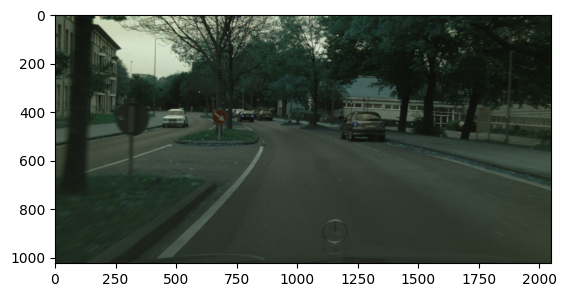

In [96]:
plt.imshow(read_images(image_paths[150]))

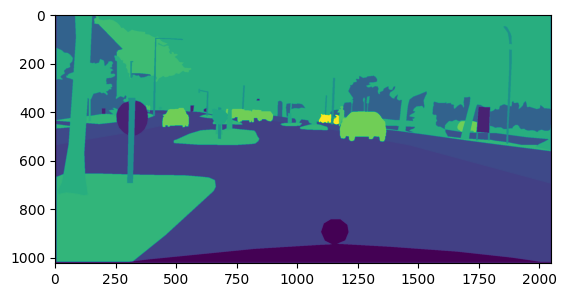

In [102]:
plt.imshow(read_images(mask_paths[150])[:,:,0])

In [126]:
y = torchvision.io.read_image(mask_paths[150], mode=torchvision.io.ImageReadMode.GRAY)

In [127]:
z = torchvision.transforms.Compose([
            torchvision.transforms.Resize((512,1024))
        ])

In [128]:
y = z(y)

/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


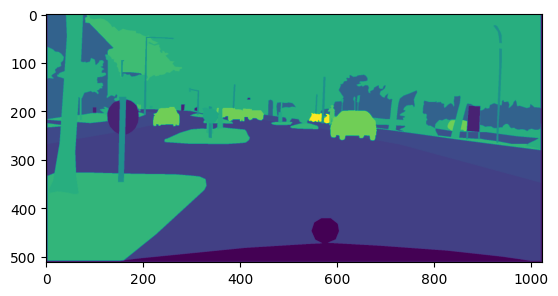

In [105]:
y[0, 5:10, 5:10]

tensor([[ 3, 11, 11, 11, 11],
        [ 3, 11, 11, 11, 11],
        [ 3, 11, 11, 11, 11],
        [ 3, 11, 11, 11, 11],
        [ 3, 11, 11, 11, 11]], dtype=torch.uint8)

In [106]:
y = read_images(mask_paths[150])

In [108]:
y[ 5:10, 5:10, 0]

array([[ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11]], dtype=uint8)

In [91]:
z =  np.array(y[5:10, 5:10,0], dtype=np.uint8)

In [82]:
z

array([[ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11],
       [ 3, 11, 11, 11, 11]], dtype=uint8)

In [121]:
class LoadData(torch.utils.data.Dataset):
    def __init__(self, train_imgs, mask_imgs):

        self.image_path = train_imgs
        self.image_mask = mask_imgs

        self.apply_transformations = torchvision.transforms.Compose([
            torchvision.transforms.Resize((512,1024))
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        image_path = self.image_path[index]
        mask_path = self.image_mask[index]

        image_raw = torchvision.io.read_image(image_path, mode=torchvision.io.ImageReadMode.RGB)
        label_raw = torchvision.io.read_image(mask_path, mode=torchvision.io.ImageReadMode.GRAY)

        image = self.apply_transformations(image_raw)
        label = self.apply_transformations(label_raw)

        return image, label


In [122]:
traindata = LoadData("image_paths", "mask_paths")

In [131]:
train_loader = DataLoader(traindata,batch_size=1, num_workers=2)